# Image segmentaion with masked facies

Squish rectangular images to square

In [93]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [94]:
import sys
from numbers import Integral
from random import uniform
from PIL import Image as pil_image
import fastai
from fastai.vision import *
from fastai.vision import Image
from fastai.vision.transform import _minus_epsilon
from fastai.vision.data import SegmentationProcessor
from fastai.vision.interpret import SegmentationInterpretation
from mask_functions import *
from collections import defaultdict
import cv2
from IPython.display import display 
import datetime
import uuid

In [95]:
fastai.__version__

'1.0.60.dev0'

In [96]:
#np.set_printoptions(threshold=sys.maxsize)

In [97]:
torch.cuda.set_device(0)

In [98]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')    

UID: 70c58d77, DATE: 20191222


In [99]:
#UID='0d3edb45'
#DATE='20191214'

In [100]:
SUBSET_DATA=False
SUBSET_LEN=171

In [101]:
tgt_height = 256
data_dir = Path('../data')
train_images = data_dir/'train_images'
train_path = train_images/'2200'
cropped_train_mask = train_path/'masked/cropped'
cropped_train_mask_6_colour = train_path/'masked/cropped_6_colour'
cropped_train_img = train_path/'GR/cropped'
train_img = train_path/'GR'
train_mask = train_path/'masked'

test_base = data_dir/'test_images'
test_img = test_base/'2200/cropped'

In [102]:
filename = data_dir/'CAX_LogFacies_Train_File.csv'

#### all data

In [103]:
training_data = pd.read_csv(filename)
training_data.head()
training_data['well_file']='well_'+training_data['well_id'].astype(str)+'.png'
wells=training_data['well_file'].unique()
all_wells_df=pd.DataFrame(wells)
all_wells_df.head()
    
df_val = all_wells_df.sample(frac=0.2)
idx=df_val.index
df_trn=all_wells_df[~all_wells_df.index.isin(idx)]
assert len(df_val)+len(df_trn)==len(all_wells_df)
#df_val.to_csv(train_path/'val_20pct.csv', index=False, header=False)

In [104]:
df_val.tail()

,0
3526,well_3526.png
3133,well_3133.png
3992,well_3992.png
2274,well_2274.png
3614,well_3614.png


#### Subset

In [105]:
df_val = pd.read_csv(train_images/'mask_fill/train/val_20pct.csv', names=["well_id"])
ids=range(0,SUBSET_LEN)
well_names=[]
for i in ids:
    well_names.append('well_'+str(i)+'.png')
df_sub_val=df_val.loc[df_val['well_id'].isin(well_names)]
#df_sub_val.to_csv(train_sub_path/'val_sub_20pct.csv', index=False, header=False)

### Data

In [106]:
train_img_names = get_image_files(train_img)
len(train_img_names)

4000

In [107]:
train_img_names[:3]

[PosixPath('../data/train_images/2200/GR/well_2640.png'),
 PosixPath('../data/train_images/2200/GR/well_2552.png'),
 PosixPath('../data/train_images/2200/GR/well_1321.png')]

In [108]:
train_mask_names = get_image_files(train_mask)
train_mask_names[:3]

[PosixPath('../data/train_images/2200/masked/well_2640.png'),
 PosixPath('../data/train_images/2200/masked/well_2552.png'),
 PosixPath('../data/train_images/2200/masked/well_1321.png')]

### Data QC

In [109]:
inames=[]
mnames=[]
for im in train_img_names:
    inames.append(im.name)
for im in train_mask_names:
    mnames.append(im.name)

In [110]:
train_img_names[0]

PosixPath('../data/train_images/2200/GR/well_2640.png')

In [111]:
missing_i_m=set(inames) - set(mnames)

In [112]:
missing_m_i= set(mnames)-set(inames) 

In [113]:
assert len(missing_i_m)==len(missing_m_i)==0

In [114]:
len(inames)

4000

In [115]:
len(mnames)

4000

In [116]:
inames.sort()
mnames.sort()

In [117]:
len(inames)

4000

In [118]:
for im,mm in zip(inames, mnames):
    assert im==mm
    img=train_img/f'{im}'
    mmg=train_mask/f'{mm}'
    img_ =pil_image.open(img)
    mmg_ =pil_image.open(mmg)
    if img_.size != mmg_.size:
        print(f'img_.size: {img_.size} != mmg_.size: {mmg_.size}')

../data/train_images/2200/GR/well_1770.png


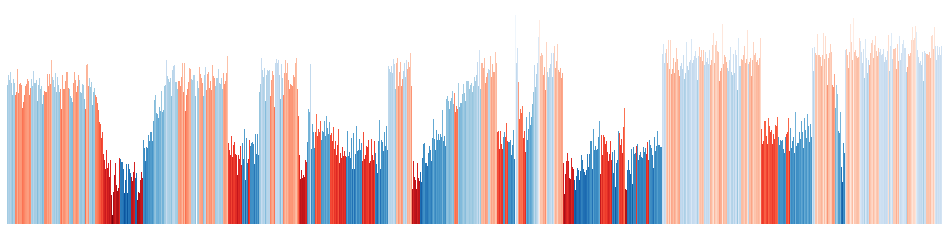

In [119]:
img_f = train_img_names[5]
print(img_f)
img_gr = open_image(img_f)
img_gr.show(figsize=(18,4))

In [120]:
img_h, img_w=img_gr.size

In [121]:
img_w

2200

In [122]:
img_h

512

In [123]:
get_y_fn = lambda x: train_mask/f'{x.stem}{x.suffix}' # converts from image to mask file namez

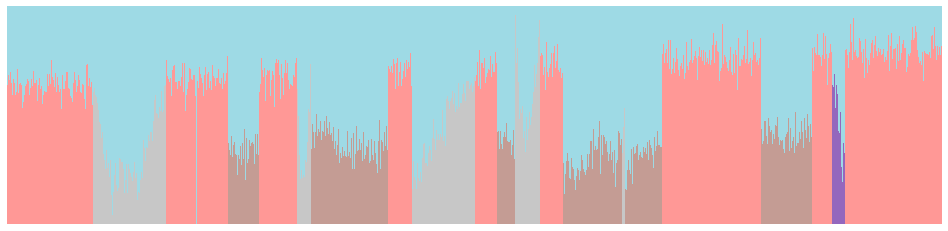

In [124]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(18,4), alpha=1)

In [125]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([ 512, 2200]), tensor([[[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [ 99,  99,  99,  ...,  99,  99,  99],
          [ 99,  99,  99,  ...,  99,  99,  99],
          [ 99,  99,  99,  ...,  99,  99,  99]]]))

In [126]:
mask.data.shape

torch.Size([1, 512, 2200])

In [127]:
np.unique(mask.data.numpy())

array([ 99, 112, 152, 195, 199, 255])

In [128]:
img_fn = train_img_names[30]
mask = open_mask(get_y_fn(img_fn))
np.unique(mask.data.numpy())

array([ 99, 112, 152, 195, 199, 255])

Check what the unique colours are in the masks generated in matplotlib

In [129]:
im = pil_image.open(get_y_fn(img_fn))
from collections import defaultdict
by_color = defaultdict(int)
for pixel in im.getdata():
    by_color[pixel] += 1
by_color

defaultdict(int,
            {(255, 255, 255, 255): 494016,
             (31, 119, 180, 255): 447574,
             (44, 160, 44, 255): 61988,
             (174, 199, 232, 255): 17232,
             (255, 187, 120, 255): 68656,
             (255, 127, 14, 255): 36934})

In [130]:
im = pil_image.open(get_y_fn(img_f))
from collections import defaultdict
by_color = defaultdict(int)
for pixel in im.getdata():
    by_color[pixel] += 1
by_color

defaultdict(int,
            {(255, 255, 255, 255): 503809,
             (174, 199, 232, 255): 54546,
             (31, 119, 180, 255): 408689,
             (44, 160, 44, 255): 7654,
             (255, 187, 120, 255): 35536,
             (255, 127, 14, 255): 116166})

### Convert masks to n color values only

We now convert the 0-255 range pixel values to 0-5 range

NB these were generated using the tab20 cmap in mpl (previous version used a bespoke cmap list)

In [131]:
f_u_values=[]
def fai_get_all_uniques(images):
    for im in images:
        mask = open_mask(get_y_fn(im))
        f_u_values.extend(np.unique(mask.data.numpy().tolist()))
    return f_u_values

In [132]:
train_mask_names

[PosixPath('../data/train_images/2200/masked/well_2640.png'),
 PosixPath('../data/train_images/2200/masked/well_2552.png'),
 PosixPath('../data/train_images/2200/masked/well_1321.png'),
 PosixPath('../data/train_images/2200/masked/well_1001.png'),
 PosixPath('../data/train_images/2200/masked/well_2711.png'),
 PosixPath('../data/train_images/2200/masked/well_1770.png'),
 PosixPath('../data/train_images/2200/masked/well_2758.png'),
 PosixPath('../data/train_images/2200/masked/well_674.png'),
 PosixPath('../data/train_images/2200/masked/well_605.png'),
 PosixPath('../data/train_images/2200/masked/well_3079.png'),
 PosixPath('../data/train_images/2200/masked/well_984.png'),
 PosixPath('../data/train_images/2200/masked/well_3031.png'),
 PosixPath('../data/train_images/2200/masked/well_1303.png'),
 PosixPath('../data/train_images/2200/masked/well_51.png'),
 PosixPath('../data/train_images/2200/masked/well_2389.png'),
 PosixPath('../data/train_images/2200/masked/well_3176.png'),
 PosixPath('.

In [133]:
np.unique(np.asarray(pil_image.open(train_mask_names[0])))

array([ 14,  31,  44, 119, 120, 127, 160, 174, 180, 187, 199, 232, 255], dtype=uint8)

In [134]:
def get_colours(images):
    for i, im in enumerate(images):
        img=pil_image.open(im)
        colors = img.convert('RGB').getcolors()
        print(colors)
        assert True==False

In [135]:
unique_pixels=[
    [255, 255, 255], 
    [174, 199, 232], 
    [31, 119, 180], 
    [44, 160, 44], 
    [255, 187, 120], 
    [255, 127, 14]]

In [136]:
c_pixels=[
    [0, 0, 0], 
    [1, 1, 1], 
    [2, 2, 2], 
    [3, 3, 3], 
    [4, 4, 4], 
    [5, 5, 5]]

In [137]:
u_values=[]
def get_all_uniques(images, subset=None):
    for i, im in enumerate(images):
        if subset and (i > subset):
            return u_values
        mask = np.asarray(pil_image.open(im))
        print(mask.shape)
        #remove opcacity
        #a=mask[:,:,:-1]
        a=mask[:,:1,:-1]
        print(a.shape)
        #u_values.extend(np.unique(mask.tolist()))
        print(a)
        assert True==False
    return u_values

In [138]:
def convert_masks_pixels(unique_pixels,unique_colours, images, save_path):
    print(f'>>convert_masks_pixels() colours: {len(u_values)} images: {len(images)} to {save_path}')
    for i, im in enumerate(images):
        mask = np.asarray(pil_image.open(im))
        mask_c=mask[:,:,:-1].copy()
        for p, c in zip(unique_pixels, unique_colours):
            mask_c[np.where((mask_c==p).all(axis=2))] = c
        #print(f'mask_c: {mask_c}')
        #print(f'mask: {mask}')
        #print(f'mask_c: {mask_c.shape}, mask: {mask.shape}')
        #assert True==False
        image = pil_image.fromarray(mask_c)
        name=im.name.split('.png')[0]
        image.save(save_path/f'{name}_replaced.png')

In [139]:
train_mask_names_mpl = get_image_files(cropped_train_mask)

In [140]:
convert_masks_pixels(unique_pixels, c_pixels, train_mask_names_mpl, cropped_train_mask_6_colour)

>>convert_masks_pixels() colours: 0 images: 32000 to ../data/train_images/2200/masked/cropped_6_colour


### QC

In [62]:
def get_unique_colours(img_name):
    im = pil_image.open(img_name)
    by_color = defaultdict(int)
    for pixel in im.getdata():
        by_color[pixel] += 1
    return by_color

In [141]:
train_mask_names_mpl[4]

PosixPath('../data/train_images/2200/masked/cropped/well_3787_crop_4.png')

In [142]:
crop_mask =data_dir/'train_images/cropped/mask_fill/train/masks'
mask_6_colour_names = get_image_files(cropped_train_mask_6_colour)

In [143]:
get_unique_colours(mask_6_colour_names[50])

NameError: name 'get_unique_colours' is not defined

In [ ]:
mpl_im = pil_image.open(train_mask_names_mpl[10])
mpl_a=np.array(mpl_im)
mpl_a.shape

In [ ]:
crop_im = pil_image.open(mask_6_colour_names[10])
crop_a=np.array(crop_im)
crop_a.shape

In [ ]:
mask = open_mask(train_mask_names_mpl[10])
mask.show(figsize=(18,4), alpha=1)

In [ ]:
crop_mask = open_mask(mask_6_colour_names[10])
crop_mask.show(figsize=(18,4), alpha=1)

### End main section

### Appendix

If need to convert 3 channel RGB to single channel

In [97]:
r=crop_a[:,:,1]

In [104]:
r=r*40

In [105]:
r.shape

(275, 275)

In [106]:
r_im=pil_image.fromarray(r)

In [107]:
r_im.save('single_channel_mask.png')

In [113]:
def convert_mask_to_single_channel(masks, out_path):
    for m in masks:
        name=m.name
        crop_im = pil_image.open(m)
        crop_a=np.array(crop_im)
        r=crop_a[:,:,1]
        r_im=pil_image.fromarray(r)
        r_im.save(out_path/name)
    

In [114]:
sc_mask_path =data_dir/'train_images/cropped/mask_fill/train/sc_masks'
convert_mask_to_single_channel(crop_mask_names,sc_mask_path)

Create a list of RGB values in order of idx value to replace with, i.e. 0: [0,0,0], 1: [255,0,0]

Note we have an extra colour for background (where GR is > log value but less than absolute GR cutoff)

We use RGB not RGBA

In [38]:
facies_rgb_list = [
    [255, 255, 255],
    [153, 102, 51],
    [0, 128, 0],
    [255, 0, 0],
    [0, 0, 255],
    [255, 255, 0]]

In [39]:
def div_rgbs(rgb_list):
    rgb_zero_one=[]
    for l in rgb_list:
        rgb_zero_one.append([i /255 for i in l])
    return rgb_zero_one

In [40]:
def convert_mask(old_mask, rgb_list, div):
    '''
    create a bytemask for pixels = rgb value to be replaced, 
    sum over all columns
    fill in pixels with new idx value
    '''
    new_mask = torch.zeros((old_mask.shape[-2],old_mask.shape[-1]))
    for idx, rgb in enumerate(rgb_list):
        rgb_mask = torch.sum(old_mask.data.view((3,-1)).permute(1,0) == tensor(rgb),dim=1)==3 
        new_mask.masked_fill_(rgb_mask.view(new_mask.shape), tensor(idx)) 
    if div: 
        new_mask.div_(255)
    print(f'max: {torch.max(new_mask)}, div: {div}')
    return ImageSegment(new_mask.unsqueeze(0))

def open_mask_converted(fn:PathOrStr, div, convert_mode='RGB', after_open:Callable=None, rgb_list=facies_rgb_list)->ImageSegment:
    '''Note we apply div after opening and conversion'''
    return convert_mask(open_image(fn, div=False, convert_mode=convert_mode, cls=ImageSegment, after_open=after_open), rgb_list, div=div)